In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c alpha-dent

100% 4.54G/4.56G [00:40<00:00, 184MB/s]
100% 4.56G/4.56G [00:40<00:00, 120MB/s]


In [7]:
!unzip alpha-dent.zip -d ./alpha_dent_dat

Archive:  alpha-dent.zip
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_000.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_001.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_002.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_003.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_004.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_005.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_006.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_007.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_008.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_009.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_010.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_011.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_012.jpg  
  inflating: ./alpha_dent_dat/AlphaDent/images/test/test_013.jpg  
  inflating: ./alpha_dent_dat/AlphaDe

In [8]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(ImprovedUNet, self).__init__()

        # Encoder
        self.enc1_1 = self._conv_block(in_channels, 64)
        self.enc1_2 = self._conv_block(64, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = self._conv_block(64, 128)
        self.enc2_2 = self._conv_block(128, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = self._conv_block(128, 256)
        self.enc3_2 = self._conv_block(256, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = self._conv_block(256, 512)
        self.enc4_2 = self._conv_block(512, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck1 = self._conv_block(512, 1024)
        self.bottleneck2 = self._conv_block(1024, 1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1_1 = self._conv_block(1024, 512)
        self.dec1_2 = self._conv_block(512, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2_1 = self._conv_block(512, 256)
        self.dec2_2 = self._conv_block(256, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3_1 = self._conv_block(256, 128)
        self.dec3_2 = self._conv_block(128, 128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4_1 = self._conv_block(128, 64)
        self.dec4_2 = self._conv_block(64, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        # Initialize weights
        self._initialize_weights()

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1_2(self.enc1_1(x))
        pool1 = self.pool1(enc1)

        enc2 = self.enc2_2(self.enc2_1(pool1))
        pool2 = self.pool2(enc2)

        enc3 = self.enc3_2(self.enc3_1(pool2))
        pool3 = self.pool3(enc3)

        enc4 = self.enc4_2(self.enc4_1(pool3))
        pool4 = self.pool4(enc4)

        # Bottleneck
        bottleneck = self.bottleneck2(self.bottleneck1(pool4))

        # Decoder with skip connections
        up1 = self.upconv1(bottleneck)
        merge1 = torch.cat([up1, enc4], dim=1)
        dec1 = self.dec1_2(self.dec1_1(merge1))

        up2 = self.upconv2(dec1)
        merge2 = torch.cat([up2, enc3], dim=1)
        dec2 = self.dec2_2(self.dec2_1(merge2))

        up3 = self.upconv3(dec2)
        merge3 = torch.cat([up3, enc2], dim=1)
        dec3 = self.dec3_2(self.dec3_1(merge3))

        up4 = self.upconv4(dec3)
        merge4 = torch.cat([up4, enc1], dim=1)
        dec4 = self.dec4_2(self.dec4_1(merge4))

        # Final output
        output = self.final_conv(dec4)
        return torch.sigmoid(output)

In [12]:
def parse_txt_annotation(txt_path, img_shape, annotation_format='yolo'):
    mask = np.zeros(img_shape, dtype=np.uint8)

    if not os.path.exists(txt_path):
        return mask

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    height, width = img_shape

    for line in lines:
        line = line.strip()
        if not line:
            continue

        parts = line.split()

        if annotation_format == 'yolo':
            # YOLO
            if len(parts) >= 5:
                class_id, center_x, center_y, w, h = map(float, parts[:5])

                center_x *= width
                center_y *= height
                w *= width
                h *= height

                x1 = int(center_x - w/2)
                y1 = int(center_y - h/2)
                x2 = int(center_x + w/2)
                y2 = int(center_y + h/2)

                x1 = max(0, min(x1, width-1))
                y1 = max(0, min(y1, height-1))
                x2 = max(0, min(x2, width-1))
                y2 = max(0, min(y2, height-1))

                # Fill
                mask[y1:y2, x1:x2] = 255

        elif annotation_format == 'polygon':
            if len(parts) >= 7:
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))

                points = np.array(coords).reshape(-1, 2)

                # convert to pixels
                if np.all(points <= 1.0):
                    points[:, 0] *= width
                    points[:, 1] *= height

                points = points.astype(np.int32)

                # Fill polygon
                cv2.fillPoly(mask, [points], 255)

        elif annotation_format == 'coco':
            # COCO format
            if len(parts) >= 5:
                class_id, x, y, w, h = map(float, parts[:5])

                x1, y1 = int(x), int(y)
                x2, y2 = int(x + w), int(y + h)

                # Ensure coordinates are within image bounds
                x1 = max(0, min(x1, width-1))
                y1 = max(0, min(y1, height-1))
                x2 = max(0, min(x2, width-1))
                y2 = max(0, min(y2, height-1))

                mask[y1:y2, x1:x2] = 255

        elif annotation_format == 'points':
            # Points format
            coords = list(map(float, parts))
            if len(coords) >= 4 and len(coords) % 2 == 0:
                points = np.array(coords).reshape(-1, 2)

                if np.all(points <= 1.0):
                    points[:, 0] *= width
                    points[:, 1] *= height

                points = points.astype(np.int32)

                # Create contour and fill
                if len(points) >= 3:
                    cv2.fillPoly(mask, [points], 255)

    return mask

In [13]:
def detect_annotation_format(txt_path):
    if not os.path.exists(txt_path):
        return 'yolo'  # default

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    if not lines:
        return 'yolo'

    for line in lines:
        line = line.strip()
        if line:
            parts = line.split()
            if len(parts) >= 5:
                # Try to determine format based on values
                coords = [float(x) for x in parts[1:5]]

                # If all coordinates are between 0 and 1, likely YOLO format
                if all(0 <= coord <= 1 for coord in coords):
                    return 'yolo'
                # If coordinates are larger, likely COCO or polygon format
                else:
                    return 'coco'
            elif len(parts) > 6:
                return 'polygon'
            break

    return 'yolo'  # default

In [14]:
class DentalDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_list, transform=None, annotation_format='auto'):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.image_list = image_list
        self.transform = transform
        self.annotation_format = annotation_format

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]

        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise ValueError(f"Could not load image: {img_path}")

        base_name = os.path.splitext(img_name)[0]
        txt_name = base_name + '.txt'
        txt_path = os.path.join(self.annotations_dir, txt_name)

        if self.annotation_format == 'auto':
            format_type = detect_annotation_format(txt_path)
        else:
            format_type = self.annotation_format

        # text to mask
        mask = parse_txt_annotation(txt_path, image.shape, format_type)

        # Normalize
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # Add channel dimension
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=0)
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=0)

        return torch.FloatTensor(image), torch.FloatTensor(mask)

In [15]:
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.OneOf([
        A.GridDistortion(p=1.0),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),
    ], p=0.3),
])

val_transform = A.Compose([
    A.Resize(512, 512),
])

/tmp/ipython-input-1648065043.py:6: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/tmp/ipython-input-1648065043.py:7: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipython-input-1648065043.py:10: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),


In [16]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.flatten()
        targets = targets.flatten()

        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

    def forward(self, predictions, targets):
        bce = self.bce_loss(predictions, targets)
        dice = self.dice_loss(predictions, targets)
        return self.bce_weight * bce + self.dice_weight * dice

def dice_coefficient(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [17]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, masks) in enumerate(pbar):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks).item()
        total_iou += iou_score(outputs, masks).item()

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Dice': f'{dice_coefficient(outputs, masks).item():.4f}',
            'IoU': f'{iou_score(outputs, masks).item():.4f}'
        })

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)

In [18]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice_coefficient(outputs, masks).item():.4f}',
                'IoU': f'{iou_score(outputs, masks).item():.4f}'
            })

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path):
    best_val_dice = 0
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    train_ious, val_ious = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')

        train_loss, train_dice, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)

        val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)
        train_ious.append(train_iou)
        val_ious.append(val_iou)

        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}')
        print(f'Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_dice': best_val_dice,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_dices': train_dices,
                'val_dices': val_dices,
                'train_ious': train_ious,
                'val_ious': val_ious
            }, save_path)
            print(f'Model saved with validation Dice: {val_dice:.4f}')

    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious

In [20]:
def predict_single_image(model, image_path, device, transform=None):
    model.eval()

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_size = image.shape

    image = image.astype(np.float32) / 255.0

    if transform:
        transformed = transform(image=image)
        image = transformed['image']

    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=0)

    image = torch.FloatTensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image)
        prediction = torch.sigmoid(prediction)
        prediction = prediction.squeeze().cpu().numpy()

    prediction = cv2.resize(prediction, (original_size[1], original_size[0]))

    return prediction

In [21]:
def visualize_annotation(image_path, txt_path, annotation_format='auto'):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    if annotation_format == 'auto':
        annotation_format = detect_annotation_format(txt_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = parse_txt_annotation(txt_path, gray_image.shape, annotation_format)

    overlay = image.copy()
    overlay[mask > 0] = [0, 255, 0]  # Green overlay
    result = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Generated Mask ({annotation_format} format)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
def test_annotation_parsing(images_dir, annotations_dir, num_samples=5):
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for i, img_name in enumerate(image_files[:num_samples]):
        print(f"\nTesting annotation for: {img_name}")

        img_path = os.path.join(images_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        txt_path = os.path.join(annotations_dir, base_name + '.txt')

        if not os.path.exists(txt_path):
            print(f"No annotation file found: {txt_path}")
            continue

        # Detect format
        detected_format = detect_annotation_format(txt_path)
        print(f"Detected annotation format: {detected_format}")

        with open(txt_path, 'r') as f:
            lines = f.readlines()[:3]
            print("Annotation content (first 3 lines):")
            for line in lines:
                print(f"  {line.strip()}")

        # Visualize
        visualize_annotation(img_path, txt_path)

In [23]:
def convert_txt_to_masks(images_dir, annotations_dir, masks_output_dir, annotation_format='auto'):
    os.makedirs(masks_output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for img_name in tqdm(image_files, desc="Converting annotations to masks"):
        img_path = os.path.join(images_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        txt_path = os.path.join(annotations_dir, base_name + '.txt')

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        if annotation_format == 'auto':
            format_type = detect_annotation_format(txt_path)
        else:
            format_type = annotation_format

        mask = parse_txt_annotation(txt_path, image.shape, format_type)

        mask_name = base_name + '.png'
        mask_path = os.path.join(masks_output_dir, mask_name)
        cv2.imwrite(mask_path, mask)

In [24]:
def visualize_results(image, mask, prediction, title="Segmentation Results"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(prediction, cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [27]:
def main():
    config = {
        'data_dir': '/content/alpha_dent_dat/AlphaDent',
        'images_dir': '/content/alpha_dent_dat/AlphaDent/images/train',
        'annotations_dir': '/content/alpha_dent_dat/AlphaDent/labels/train',
        'annotation_format': 'auto',
        'batch_size': 4,
        'learning_rate': 1e-4,
        'num_epochs': 10,
        'model_save_path': 'best_unet_model.pth',
        'convert_masks': False,
        'masks_output_dir': '/content/'
    }

    print("Testing annotation parsing...")
    test_annotation_parsing(config['images_dir'], config['annotations_dir'], num_samples=3)

    # if config['convert_masks']:
    #     print("Converting text annotations to mask images...")
    #     convert_txt_to_masks(
    #         config['images_dir'],
    #         config['annotations_dir'],
    #         config['masks_output_dir'],
    #         config['annotation_format']
    #     )

    # all_files = os.listdir(config['images_dir'])
    # print(f"All files in {config['images_dir']}: {all_files[:10]}...")

    # image_files = [f for f in all_files if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
    # print(f"Found {len(image_files)} images")


    # train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    # print(f"Training on {len(train_files)} images, validating on {len(val_files)} images")

    # train_dataset = DentalDataset(
    #     config['images_dir'],
    #     config['annotations_dir'],
    #     train_files,
    #     transform=train_transform,
    #     annotation_format=config['annotation_format']
    # )
    # val_dataset = DentalDataset(
    #     config['images_dir'],
    #     config['annotations_dir'],
    #     val_files,
    #     transform=val_transform,
    #     annotation_format=config['annotation_format']
    # )

    # train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
    # val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

    # model = ImprovedUNet(in_channels=1, num_classes=1).to(device)

    # criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    # optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    # print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

    # train_losses, val_losses, train_dices, val_dices, train_ious, val_ious = train_model(
    #     model, train_loader, val_loader, criterion, optimizer, scheduler,
    #     config['num_epochs'], device, config['model_save_path']
    # )

    # plt.figure(figsize=(15, 5))

    # plt.subplot(1, 3, 1)
    # plt.plot(train_losses, label='Train Loss')
    # plt.plot(val_losses, label='Val Loss')
    # plt.title('Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()

    # plt.subplot(1, 3, 2)
    # plt.plot(train_dices, label='Train Dice')
    # plt.plot(val_dices, label='Val Dice')
    # plt.title('Dice Coefficient')
    # plt.xlabel('Epoch')
    # plt.ylabel('Dice')
    # plt.legend()

    # plt.subplot(1, 3, 3)
    # plt.plot(train_ious, label='Train IoU')
    # plt.plot(val_ious, label='Val IoU')
    # plt.title('IoU Score')
    # plt.xlabel('Epoch')
    # plt.ylabel('IoU')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()

    print("Training completed!")

Testing annotation parsing...

Testing annotation for: p156_M_36_001.jpg
Detected annotation format: yolo
Annotation content (first 3 lines):
  5 0.58168860 0.41474781 0.58059211 0.41639254 0.58040936 0.41639254 0.57931287 0.41803728 0.57913012 0.41803728 0.57803363 0.41968202 0.57785088 0.41968202 0.57657164 0.42160088 0.57638889 0.42160088 0.57529240 0.42324561 0.57510965 0.42324561 0.57401316 0.42489035 0.57383041 0.42489035 0.57255117 0.42680921 0.57236842 0.42680921 0.57127193 0.42845395 0.57108918 0.42845395 0.56999269 0.43009868 0.56980994 0.43009868 0.56853070 0.43201754 0.56834795 0.43201754 0.56761696 0.43311404 0.56761696 0.43366228 0.56779971 0.43393640 0.56779971 0.43585526 0.56798246 0.43612939 0.56798246 0.43832237 0.56816520 0.43859649 0.56816520 0.44078947 0.56834795 0.44106360 0.56834795 0.44325658 0.56853070 0.44353070 0.56853070 0.44544956 0.56871345 0.44572368 0.56871345 0.44791667 0.56889620 0.44819079 0.56889620 0.45038377 0.56907895 0.45065789 0.56907895 0.45285

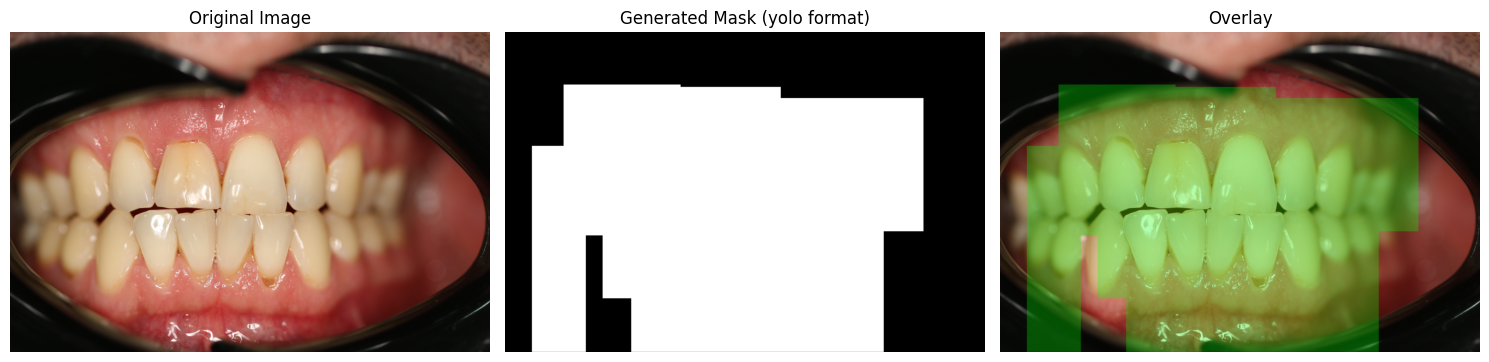


Testing annotation for: p222_M_28_001.jpg
Detected annotation format: yolo
Annotation content (first 3 lines):
  1 0.65200617 0.34693287 0.65181327 0.34722222 0.65084877 0.34722222 0.65065586 0.34751157 0.64969136 0.34751157 0.64949846 0.34780093 0.64853395 0.34780093 0.64834105 0.34809028 0.64737654 0.34809028 0.64718364 0.34837963 0.64621914 0.34837963 0.64602623 0.34866898 0.64506173 0.34866898 0.64486883 0.34895833 0.64390432 0.34895833 0.64371142 0.34924769 0.64274691 0.34924769 0.64255401 0.34953704 0.64158951 0.34953704 0.64139660 0.34982639 0.64043210 0.34982639 0.64023920 0.35011574 0.63946759 0.35011574 0.63869599 0.35127315 0.63850309 0.35127315 0.63252315 0.36024306 0.63233025 0.36024306 0.62712191 0.36805556 0.62731481 0.36834491 0.62750772 0.36834491 0.62770062 0.36863426 0.62789352 0.36863426 0.62808642 0.36892361 0.62827932 0.36892361 0.62847222 0.36921296 0.62866512 0.36921296 0.62885802 0.36950231 0.62905093 0.36950231 0.62924383 0.36979167 0.62943673 0.36979167 0.62

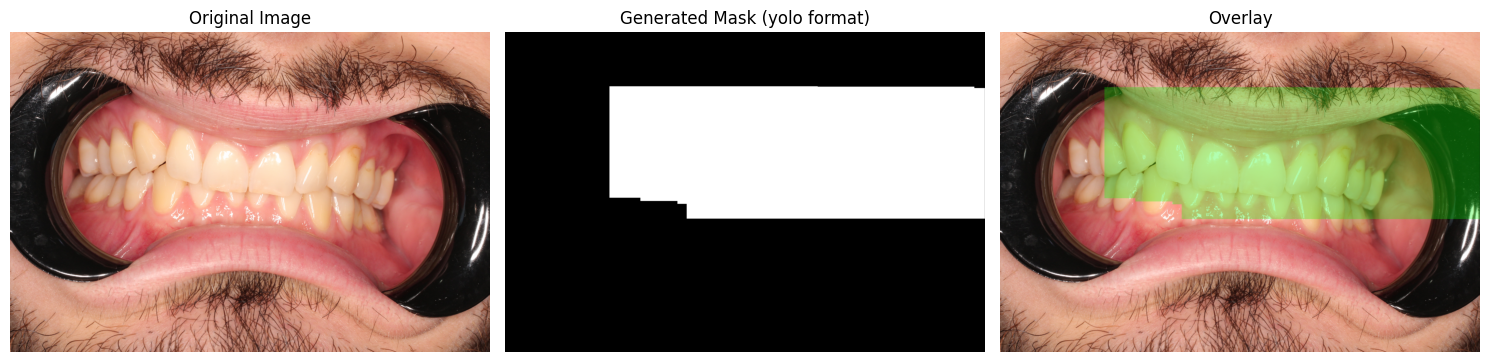


Testing annotation for: p135_F_37_003.jpg
Detected annotation format: yolo
Annotation content (first 3 lines):
  0 0.62225877 0.19654605 0.62225877 0.19682018 0.62171053 0.19764254 0.62171053 0.19791667 0.62097953 0.19901316 0.62097953 0.19928728 0.62043129 0.20010965 0.62043129 0.20038377 0.61988304 0.20120614 0.61988304 0.20148026 0.61933480 0.20230263 0.61933480 0.20257675 0.61878655 0.20339912 0.61878655 0.20367325 0.61823830 0.20449561 0.61823830 0.20476974 0.61769006 0.20559211 0.61769006 0.20586623 0.61695906 0.20696272 0.61695906 0.20723684 0.61641082 0.20805921 0.61641082 0.20833333 0.61586257 0.20915570 0.61586257 0.20942982 0.61531433 0.21025219 0.61531433 0.21052632 0.61476608 0.21134868 0.61476608 0.21162281 0.61421784 0.21244518 0.61421784 0.21271930 0.61366959 0.21354167 0.61366959 0.21381579 0.61293860 0.21491228 0.61293860 0.21518640 0.61239035 0.21600877 0.61239035 0.21628289 0.61184211 0.21710526 0.61184211 0.21737939 0.61129386 0.21820175 0.61129386 0.21847588 0.61

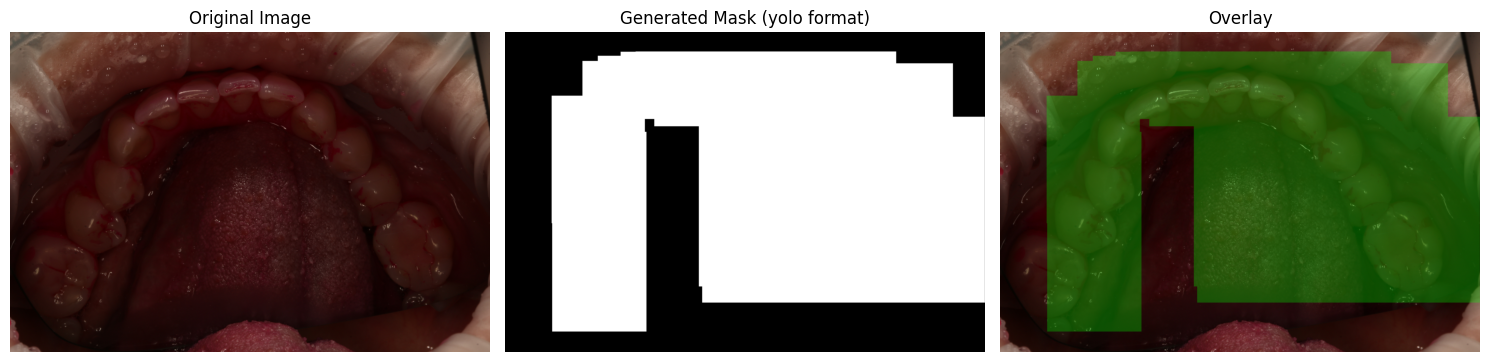

Training completed!


In [28]:
if __name__ == "__main__":
    main()